In [128]:
import matplotlib.pylab as plt
import pandas as pd
import numpy as np
from scipy import integrate

In [196]:
def ElastoPlasticShaft(Ks,js,Rs_u,Rs_v,RsL,n,i):
    """
    Static elasto-plastic shaft element model with viscous damping.
    """
    # Compute static component
    # Compute increment from spring stiffness
    Rs_u[n,i+1] = Rs_u[n,i] + Ks[n]*(u[i+1]-u[i])
    
    # Check if exceeds limit resistance
    if abs(Rs_u[n,i+1]) > RsL[n]:
        Rs_u[n,i+1] = np.sign(Rs_u[n,i+1])*RsL[n]
    
    # Compute dynamic component 
    Rs_v[n,i+1] = v[i+1]*RsL[n]*js[n]
    
    return Rs_u, Rs_v


def ElastoPlasticBase(Kb,jb,Rb_u,Rb_v,RbL):
    """
    Static elasto-plastic base element model with viscous damping.
    """
    # Compute static component
    # Compute increment from spring stiffness
    Rb_u[i+1] = Rb_u[i] + Kb*(u[i+1]-u[i])
    
    # Check if exceeds limit resistance
    if Rb_u[i+1] > RbL:
        Rb_u[i+1] = np.sign(Rb_u[i+1])*RbL
    elif Rb_u[i+1] < 0.0: # no tension limit
        Rb_u[i+1] = 0.0
    
    # Compute dynamic component 
    Rb_v[i+1] = v[i+1]*RbL*jb
    
    return Rb_u, Rb_v

In [197]:
# Create a sample input velocity history
decay = 15
amp = 3
omega = 100
t = np.linspace(0,0.25,2000)
v = amp*np.exp(-decay*t)*np.sin(omega*t)

# Integrate for displacement
u = integrate.cumtrapz(v,x=t)
v = v[:-1]
t = t[:-1]

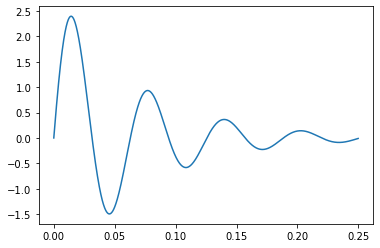

In [198]:
plt.plot(t,v)
plt.show()

In [199]:
# Initialize
Rs_u = np.zeros((1,len(t)))
Rs_v = np.zeros((1,len(t)))
Rb_u = np.zeros(len(t))
Rb_v = np.zeros(len(t))
n = 0

# Material parameters for..
# Shaft model
Ks = [1e4]
js = [0.25]
RsL = [150]

# Base model
Kb = 1e4
jb = 0.25
RbL = 150

# Compute element responses
for i, time in enumerate(t[:-1]):
    Rs_u, Rs_v = ElastoPlasticShaft(Ks,js,Rs_u,Rs_v,RsL,n,i)
    Rb_u, Rb_v = ElastoPlasticBase(Kb,jb,Rb_u,Rb_v,RbL)

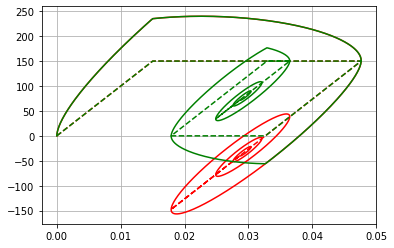

In [203]:
plt.plot(u,Rs_u[n,:],c='r',ls='--')
plt.plot(u,Rs_u[n,:]+Rs_v[n,:],c='r')
plt.plot(u,Rb_u,c='g',ls='--')
plt.plot(u,Rb_u+Rb_v,c='g')

plt.grid('on')
plt.show()

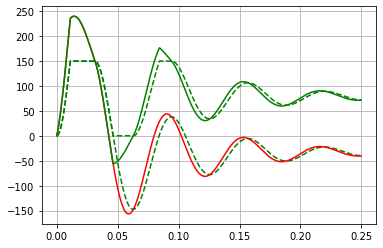

In [204]:
plt.plot(t,Rs_u[n,:],c='g',ls='--')
plt.plot(t,Rs_u[n,:]+Rs_v[n,:],c='r')
plt.plot(t,Rb_u,c='g',ls='--')
plt.plot(t,Rb_u+Rb_v,c='g')
plt.grid('on')
plt.show()

In [567]:
def CreatePile(Ap,Ep,rhop,Lp,dt):
    """
    CREATEPILE discretizes the pile into segments of equal wave travel time 
    given the pile modulus (Ep), density (rhop), areas (Ap), lengths (Lp),
    and analysis time increment (dt). A single unifrom wave speed is assumed 
    for the pile resulting in segments of equal width. 
    
    Ap and L can be paired arrays to specify intervals of area variation, 
    which can be used to introduce non-uniform intervals of impedance 
    contrasts. 
    
    The element width is enforced to be greater than the minimum interval
    length of area variation such that a segment lies maximally within two 
    distinct intervals. An area weighted averaging approach is used to assign 
    area values for such cases. The time step (dt) can be made smaller to
    minimize averaging and obtain a more accurate representation of the pile
    model, limited only by the sampling frequency.

       INPUTS
       Ap - pile area [m2]
       Ep - pile modulus [N/m2]
       rhop - pile density [kg/m3]
       Lp - pile length [m]
       dt - analysis time increment [s]
    
     Example usage:
        Lp = np.array([2, 10, 2, 10])/3.281
        Ap = np.array([96, 69, 96, 69])*1e-4
        Ep = np.array([198e9])
        rhop = np.array([7830])
        dt = np.array(0.0151*1e-3)
        pile = CreatePile_NonUniformA(Ap,Ep,rhop,Lp,dt)
    """
    # Some dimensionality checks
    if (len(Ap) != len(Lp)) or (len(Ep)*len(rhop)> 1):
        print("Numel in Ap & Lp must be equal lengths. Ep & rhop must be scalar.")
    
    # Calculate segment width
    cp = np.sqrt(Ep/rhop)         # Wave speed
    dz = cp*dt                    # Element length
    
    Np = np.int(np.round(np.sum(Lp)/dz))  # No. pile segments
    Nint = Np + 1                         # No. pile nodes
    
    dz_false = (np.sum(Lp)/dz - Np)*dz # False length due to integer elem
    
    
    # Generate model coordinates for integer segments
    zp_intersec = np.arange(0,Np+1,1)*dz
    zp_bott = zp_intersec[1:len(zp_intersec)]
    zp_top  = zp_intersec[0:len(zp_intersec)-1]
    
    
    # Assign element properties
    if dz > np.min(Lp):
        # By ensuring the element width is less than the minimum interval
        # length of area variation in the pile, garuntees that the element will
        # at max overlap 2 regions, so can use simplified area calculations.
        print("Elem. width must be less than min. interval of area variation.")
    
    
    # Compute element properties (A, E, c, Z) ...
    L2 = np.cumsum(Lp)
    A_el = np.zeros((Np,1)) # Area
    for i in np.arange(0,Np,1):

        idx_Start = np.argwhere(zp_intersec[i]   < L2)[0]
        idx_End   = np.argwhere(zp_intersec[i+1] < L2)[0]

        if idx_End - idx_Start == 0:     # element in same region
            A_el[i] = Ap[idx_Start]
        elif idx_End - idx_Start == 1:   # overlapping between 2 regions

            x1 = L2[idx_Start] - zp_intersec[i]
            x2 = zp_intersec[i+1] - L2[idx_Start]
            A_el[i] = (Ap[idx_Start]*x1 + Ap[idx_End]*x2)/(x1+x2)

        if i == Np:  # For final element due to rounding, assign area direct
            A_el[i] = Ap[end];

    E_el = np.ones((Np,1))*Ep; # Young's modulus
    c_el = np.ones((Np,1))*cp; # Wavespeed
    Z_el = A_el*E_el/c_el;     # impedance
    
    
    # Create L/c gridlines (must add impact time)
    L_c = np.sum(Lp)/cp
    xgrid = [0,0,1,1,2,2,3,3,4,4,5,5]*L_c
    ygrid = [-1,1,1,-1,-1,1,1,-1,-1,1,1,-1]
    
    
    # Echo inputs and final pile 
    print("""Number of pile elements: {Np}""".format(Np=Np))
    print("""Time increment: {dt}(s)""".format(dt=dt))
    print("""Element width: {dz}(m)""".format(dz=dz[0]))
    print("""False length: {dz_false}(m)""".format(dz_false=dz_false[0]))
    
    
    pile = {'Np':Np,
            'Nint':Nint,
            'dt':dt,
            'dz':dz,
            'dz_false':dz_false,
            'zp_intersec':zp_intersec,
            'zp_bott':zp_bott,
            'zp_top':zp_top,
            'Z_el':Z_el,
            'A_el':A_el,
            'E_el':E_el,
            'c_el':c_el,
            'xgrid':xgrid,
            'ygrid':ygrid}
    
    return pile

In [568]:
Lp = np.array([2, 10, 2, 10])/3.281
Ap = np.array([96, 69, 96, 69])*1e-4
Ep = np.array([198e9])
rhop = np.array([7830])
dt = np.array(0.0151*1e-3)
pile = CreatePile(Ap,Ep,rhop,Lp,dt)

Number of pile elements: 96
Time increment: 1.5100000000000001e-05(s)
Element width: 0.07593266829858233(m)
False length: 0.025306878995956385(m)


In [569]:
pile.keys()

dict_keys(['Np', 'Nint', 'dt', 'dz', 'dz_false', 'zp_intersec', 'zp_bott', 'zp_top', 'Z_el', 'A_el', 'E_el', 'c_el', 'xgrid', 'ygrid'])

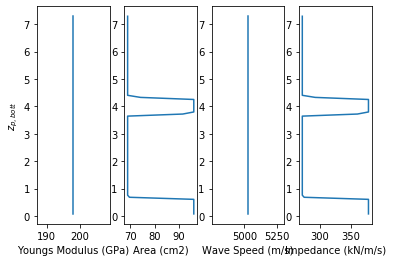

In [570]:
ax1 = plt.subplot(1,4,1)
ax1.plot(pile['E_el']/1e9,pile['zp_bott'])
ax2 = plt.subplot(1,4,2)
ax2.plot(pile['A_el']*(100**2),pile['zp_bott'])
ax3 = plt.subplot(1,4,3)
ax3.plot(pile['c_el'],pile['zp_bott'])
ax4 = plt.subplot(1,4,4)
ax4.plot(pile['Z_el']/1e3,pile['zp_bott'])

ax1.set_ylabel('$z_{p,bott}$')
ax1.set_xlabel('Young''s Modulus (GPa)')
ax2.set_xlabel('Area (cm2)')
ax3.set_xlabel('Wave Speed (m/s)')
ax4.set_xlabel('Impedance (kN/m/s)')
plt.show()

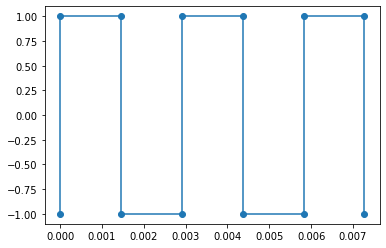

In [577]:
plt.plot(pile['xgrid'],pile['ygrid'],'-o')
plt.show()